In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.datasets as dsets
import torchvision.transforms as trans
import torchvision as tv

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy
import scipy.linalg as LN

import os,time,random
os.sys.path.insert(0,'../')
import utils
import models
import attacks

In [87]:
batch_size=200
model_path = '../pretrains/store/fnnMNIST_deep-mnist-98.66.pkl'
model_arch = 'fnnMNIST_deep'
B    = 30.0/255
step = 1
eps  = 30.0/255


train_set = dsets.MNIST(root='/home/leiwu/data/mnist',train=True, transform=trans.ToTensor(),download=True)
test_set  = dsets.MNIST(root='/home/leiwu/data/mnist',train=False,transform=trans.ToTensor(),download=False)
train_loader = torch.utils.data.DataLoader(dataset=train_set,batch_size=batch_size,shuffle=False)
test_loader  = torch.utils.data.DataLoader(dataset=test_set,batch_size=batch_size,shuffle=False)
trX,trY,teX,teY = train_set.train_data, train_set.train_labels,test_set.test_data, test_set.test_labels

model = models.__dict__[model_arch]().cuda()
model.load_state_dict(torch.load(model_path))
ct = nn.CrossEntropyLoss().cuda()

def show(img):
    img = my_makegrid(img)
    npimg = img.numpy()
    npimg = np.transpose(npimg,(1,2,0))
    plt.imshow(npimg,interpolation='nearest')
    
def my_makegrid(x):
    x = x.unsqueeze(1)
    N,C,W,H = x.size()
    x = x.expand(N,3,W,H)
    x = tv.utils.make_grid(x)
    return x

def evaluate(model,ct,x):
    test_img = test_set.test_data.clone()
    test_set.test_data.copy_(x)
    _,acc,_ = utils.eval(model,ct,test_loader)
    test_set.test_data.copy_(test_img)
    return acc

Files already downloaded


In [88]:
adv_x = torch.Tensor(teX.size())
for i,(x,y) in enumerate(test_loader):
#     print(x.size())
    adv_x_batch = attacks.gsm(model,ct,x.cuda(),y.cuda(),lr=B,eps=eps,niter=step)
    adv_x[i*batch_size:(i+1)*batch_size] = adv_x_batch
adv_x = (adv_x * 255 ).byte()

accuracy on clean test set: 98.64
accuracy on clean test set: 38.02


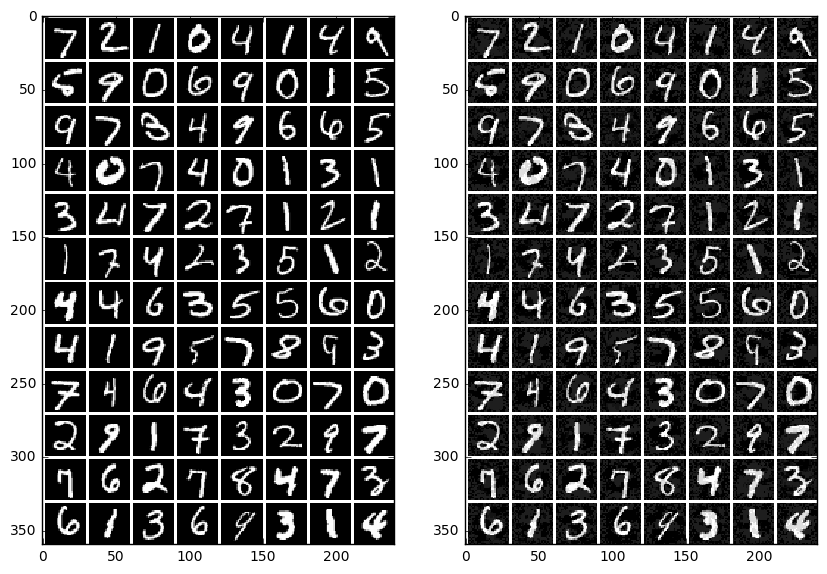

In [89]:
plt.figure(figsize=(10,12))
plt.subplot(1,2,1)
show(teX[0:100,:,:])
print('accuracy on clean test set: %.2f'%(evaluate(model,ct,teX)))

plt.subplot(1,2,2)
show(adv_x[0:100,:,:])
print('accuracy on clean test set: %.2f'%(evaluate(model,ct,adv_x)))

In [90]:
x = adv_x.unsqueeze(1).float()/255
pred=utils.predictor(model,x.cuda())
dy=torch.ones(teY.size(0)).byte()-pred.eq(teY)
idx = dy.nonzero()
idx = idx.squeeze()

pred: 

    8     3     8     2     9     7     8     3
    6     4     2     8     4     8     3     4
    9     8     7     5     9     9     2     3
[torch.LongTensor of size 3x8]

truth:

    7     2     1     0     4     1     4     9
    5     9     0     6     9     1     5     9
    7     3     9     6     4     7     0     1
[torch.LongTensor of size 3x8]



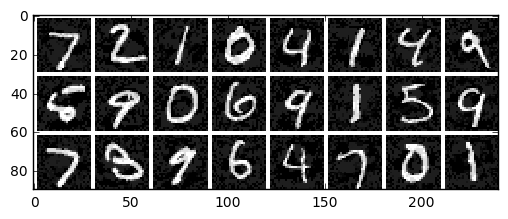

In [91]:
pred_wrong=pred.index_select(0,idx)
label_wrong = test_set.test_labels.index_select(0,idx)
adv_x_wrong = adv_x.index_select(0,idx)
show(adv_x_wrong[0:25,:,:])

print('pred: ')
print(pred_wrong[0:24].view(3,8));
print('truth:')
print(label_wrong[0:24].view(3,8))